<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/multivariate_statistical_forecacst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

##Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb
!pip install pmdarima

In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##General setup

In [4]:
%%capture
!cd npmf && git pull

import os
import pickle
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import pmdarima as pm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.wandb import get_dataset, put_dataset, put_models, get_models
from npmf.utils.data import test_start_pd, get_1_month_test_set, get_train_set
from npmf.utils.measurement import mape
from npmf.utils.eikon import col_map_macro

In [5]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (12, 4)  # (6, 4) is default and used in the paper
pd.DataFrame.np = lambda self: self.to_numpy()
pd.Series.np = lambda self: self.to_numpy()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
np.random.seed(420)

In [8]:
def plot_market_cap(df):
    plt.plot(df.date.to_numpy(), df.market_cap.to_numpy())

# Initial validation on synthetic data



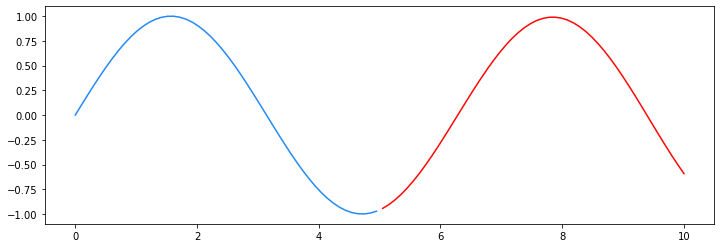

In [9]:
mod = pm.arima.AutoARIMA(seasonal=False)

xs = np.linspace(0, 10, 100)
ys = np.sin(xs)


mod.fit(ys[:-50])

fs = mod.predict(50)

plt.plot(xs[:-50], ys[:-50])
plt.plot(xs[-50:], fs)

In [16]:
def plot_pred(ax, xs, ys, f1, f2, text=""):
    ax.text(0, 3, text, va="top", ha="left", size=14)
    ax.plot(xs, ys, label="Data")
    ax.plot(xs, f1, linestyle="-.")
    ax.plot(10 + xs, f2, linestyle="-.", color=main2, label="Forecast")

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/arima.py:692: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


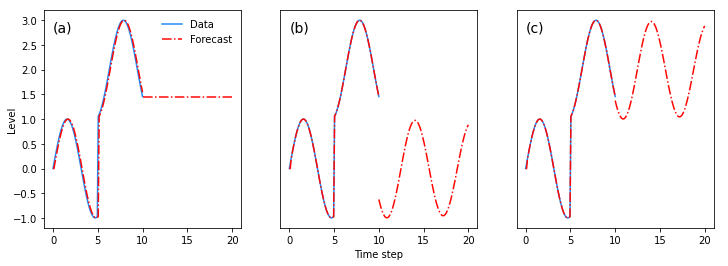

In [24]:
mod = pm.arima.AutoARIMA(seasonal=False)
xs = np.linspace(0, 10, 100)
x1 = np.concatenate((np.zeros(50), np.ones(50)))
ys = np.sin(xs) + 2 * x1

fig = plt.figure()
ax = fig.add_subplot(111)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

mod.fit(ys)
f1 = mod.predict_in_sample()
f2 = mod.predict(100)
plot_pred(ax1, xs, ys, f1, f2, "(a)")

mod.fit(ys, x1.reshape((100, 1)))
f1 = mod.predict_in_sample(x1.reshape((100, 1)))
f2 = mod.predict(100, np.zeros((100, 1)))
plot_pred(ax2, xs, ys, f1, f2, "(b)")

mod.fit(ys, x1.reshape((100, 1)))
f1 = mod.predict_in_sample(x1.reshape((100, 1)))
f2 = mod.predict(100, np.ones((100, 1)))
plot_pred(ax3, xs, ys, f1, f2, "(c)")
ax1.legend(frameon=False)
ax2.axes.yaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)

ax.set_xlabel("Time step")
ax.set_ylabel("Level")

fig.add_axes(xlabel="Time step")

# Fit ARIMAX for all tickers

## Get data and prepare

### Download from WandB

In [ ]:
%%capture
all_stck = get_dataset("stock-oil-final:v4", "master-test").set_index(["ticker", "date"]).sort_index()
all_fund = (
    get_dataset("fundamentals-oil-final:v4", "master-test")
    .astype(
        {
            "date": np.datetime64,
            "period_end_date": np.datetime64,
            "announce_date": np.datetime64,
        }
    )
    .set_index(["ticker", "announce_date"])
    .drop(columns=["period_end_date"])
    .sort_index()
)
all_macro = get_dataset("macro-oil-final:v1", "master-test").set_index("date").sort_index().rename(columns=col_map_macro)

In [ ]:
print(f"Shape stock: {all_stck.shape}, shape fundamental: {all_fund.shape}, shape macro: {all_macro.shape}")

Shape stock: (3206180, 3), shape fundamental: (41580, 17), shape macro: (5818, 8)


### Process fundamental and stock data

In [ ]:
all_stck = all_stck[~all_stck.index.duplicated(keep="first")]
all_stck.shape

(3180722, 3)

In [ ]:
all_fund = all_fund[~all_fund.index.duplicated(keep="last")]
all_fund.shape

(38419, 17)

In [ ]:
len(set(all_fund.index.levels[0]) | set(all_stck.index.levels[0])) - len(set(all_fund.index.levels[0]) & set(all_stck.index.levels[0]))

0

In [ ]:
tickers = all_fund.index.levels[0]

In [ ]:
stck = all_stck[all_stck.index.get_level_values(1) < test_start_pd]
fund = all_fund[all_fund.index.get_level_values(1) < test_start_pd]
macr = all_macro[all_macro.index < test_start_pd]

## Create the training procedure

Create the procedure in such a way that it drops constant columns because they carry no actionable information and causes the ARIMAX model to crash epically.

In [ ]:
models = dict()
errors = []

it = tqdm(tickers, desc="Training ARIMAX", postfix=dict(errors=len(errors)))

for ticker in it:
    try:

        s = stck.loc[(ticker,)]
        f = fund.loc[(ticker,)]

        s = (
            s.join(f, how="left", rsuffix="_fund")
            .join(macr, how="left", rsuffix="_macr")
            .ffill()
        )
        s = s.iloc[-60:, :]

        ys = s.market_cap
        exs = s.drop(columns=["market_cap", "close_price", "currency", "date"])
        exs = exs.loc[:, exs.nunique() > 1].dropna()

        ex_cols = exs.columns.to_list()

        mod = pm.arima.AutoARIMA(seasonal=False, error_action="ignore")
        mod.fit(ys, exs.np())

        models[ticker] = (mod, ex_cols)

    except Exception as e:
        errors.append((ticker, e))
        it.set_postfix(dict(errors=len(errors)))

## Save the trained models to WandB

In [ ]:
filename = "arimax-trained-1Q.pickle"
metadata = {
    "type": "ARIMAX",
    "n_models": len(models),
    "macro": True,
    "fundamentals": True,
}

put_models(filename, models, metadata)

# Test the fitted models on the test set

## Get the models from WandB

In [ ]:
models = get_models("arimax-trained-1Q:v0")

wandb: Currently logged in as: ankile (krankile). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact arimax-trained-1Q:v0, 97.31MB. 1 files... Done. 0:0:0


## Predict for January 2019

In [ ]:
ob_num = list(range(1, 21))
out = dict(ticker=[], market_cap=[], obs_number=[])

# Get last fundamental values for use in forecasting
fund_exo = (
    fund.reset_index()
    .drop_duplicates(subset="ticker", keep="last")
    .set_index("ticker")
    .drop(columns=["date", "announce_date"])
    .fillna(0)
)

# Get last macro data
macr_exo = macr.ffill().iloc[-1, :]


for ticker, (model, columns) in tqdm(models.items()):

    exo = pd.concat(
        [fund_exo.loc[ticker, :], macr_exo],
        axis=0,
    )[columns]

    exo = np.repeat(exo.np().reshape((1, -1)), 20, axis=0)

    forec = model.predict(20, exo)
    ts = [ticker] * 20

    out["ticker"].extend(ts)
    out["market_cap"].extend(forec)
    out["obs_number"].extend(ob_num)


forec_df = pd.DataFrame(out)

put_dataset(
    forec_df,
    "arimax-2Q-forecast-2019M1.feather",
    "master-test",
    type_="forecast",
    metadata={"model": "ARIMAX", "n_forecasts": len(models)},
)

forec_df = forec_df.set_index(["ticker", "obs_number"])

100%|██████████| 806/806 [00:04<00:00, 197.33it/s]


In [ ]:
forec_df

market_cap
ticker    obs_number              
000096.SZ 1           7.256019e+08
          2           7.288937e+08
          3           7.317511e+08
          4           7.342316e+08
          5           7.363847e+08
...                            ...
ZHEN.SI   16          4.782008e+08
          17          4.782008e+08
          18          4.782008e+08
          19          4.782008e+08
          20          4.782008e+08

[16120 rows x 1 columns]

## Create actual and compare

In [ ]:
tst = all_stck[all_stck.index.get_level_values(1) >= test_start_pd].reset_index()
tst["obs_number"] = tst.groupby("ticker").date.rank(method='first', ascending=True).astype(int)
tst = tst[tst.obs_number <= 20].set_index(["ticker", "obs_number"]).loc[:, ["market_cap"]]
tst.market_cap = tst.market_cap.astype(np.float64)
tst

market_cap
ticker    obs_number              
000096.SZ 1           6.935114e+08
          2           6.931595e+08
          3           7.005345e+08
          4           7.052744e+08
          5           7.127950e+08
...                            ...
ZHEN.SI   16          5.736022e+08
          17          5.939724e+08
          18          5.864256e+08
          19          5.869460e+08
          20          5.871631e+08

[17980 rows x 1 columns]

In [ ]:
tickers = forec_df.index.unique(level="ticker").intersection(tst.index.unique(level="ticker"))

tst = tst[tst.index.get_level_values(0).isin(tickers)]
forec_df = forec_df[forec_df.index.get_level_values(0).isin(tickers)]

In [ ]:
errors = ((tst - forec_df).abs() / tst.abs())
errors

market_cap
ticker    obs_number            
000096.SZ 1             0.046272
          2             0.051553
          3             0.044561
          4             0.041058
          5             0.033095
...                          ...
ZHEN.SI   16            0.166320
          17            0.194911
          18            0.184550
          19            0.185273
          20            0.185574

[16120 rows x 1 columns]

In [ ]:
errors.groupby("ticker").mean().mean().item()

0.0893091398716737

# Analyze the resulting models

In [ ]:
models = get_models("arimax-trained-1Q:v0")

wandb: Downloading large artifact arimax-trained-1Q:v0, 97.31MB. 1 files... Done. 0:0:0


In [ ]:
revenues = {}
for ticker, (model, columns) in tqdm(models.items()):
    if "revenue" not in columns:
        continue
    rev_idx = columns.index("revenue")
    
    revenues[ticker] = model.model_.params()[rev_idx]

100%|██████████| 806/806 [00:00<00:00, 59433.01it/s]


In [ ]:
scaled_rev = []

for ticker, revenue in tqdm(revenues.items()):
    s = stck.loc[(ticker,)]
    f = fund.loc[(ticker,)]

    s = (
        s.join(f, how="left", rsuffix="_fund")
        .join(macr, how="left", rsuffix="_macr")
        .ffill()
    )
    max_rev = s.iloc[-60:, :].revenue.max()

    scaled_rev.append(revenue / max_rev)

100%|██████████| 660/660 [00:14<00:00, 44.74it/s]


-3.4606523718397246e-06 -1.1416171784166583e-08


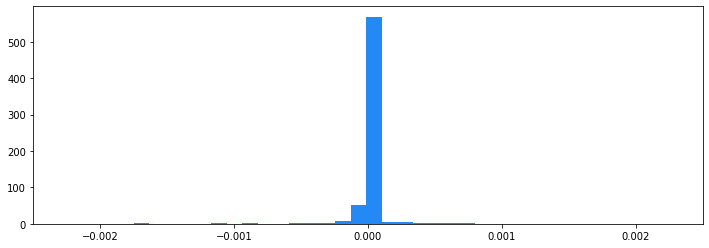

In [ ]:
print(np.mean(scaled_rev), np.median(scaled_rev))
plt.hist(scaled_rev, bins=500,)
plt.xlim(-0.0025, 0.0025);

In [ ]:
brent = {}
for ticker, (model, columns) in tqdm(models.items()):
    if "revenue" not in columns:
        continue
    rev_idx = columns.index("brt")
    
    brent[ticker] = model.model_.params()[rev_idx]

100%|██████████| 806/806 [00:00<00:00, 51222.90it/s]


In [ ]:
scld_brt_coeff = []

for ticker, brt in tqdm(brent.items()):
    s = stck.loc[(ticker,)]
    f = fund.loc[(ticker,)]

    s = (
        s.join(f, how="left", rsuffix="_fund")
        .join(macr, how="left", rsuffix="_macr")
        .ffill()
    )
    max_brt = s.iloc[-60:, :].brt.max()

    scld_brt_coeff.append(brt / max_brt)

brt_coeff = np.array(scld_brt_coeff)

100%|██████████| 660/660 [00:14<00:00, 46.03it/s]


In [ ]:
brt_coeff /= 1e6

Mean: 0.1190767872534566 Median: 0.0014910733466418317


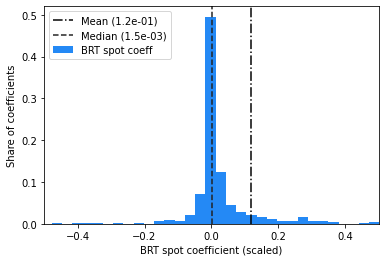

In [ ]:
mean = brt_coeff.mean()
medi = np.median(brt_coeff)

print("Mean:", mean, "Median:", medi)

plt.hist(brt_coeff, bins=500, weights=np.ones(len(brt_coeff)) / len(brt_coeff), label="BRT spot coeff");
plt.axvline(x=mean, color="black", linestyle="-.", label=f"Mean ({mean:.1e})")
plt.axvline(x=np.median(brt_coeff), color="#222", linestyle="--", label=f"Median ({medi:.1e})")
plt.xlim(-0.5, 0.5);
plt.xlabel("BRT spot coefficient (scaled)")
plt.ylabel("Share of coefficients")
plt.legend(loc=2);

# Initial experiments

The below experiments were performed in order to get familiarized with the `pmdarima` library and included here for reference.

## A little real-world data

Take one company (Aker BP) and prepare the data and test one ARIMAX-model.

In [ ]:
%%capture
stck = get_dataset("stock-oil-final:v4", "master-test")
fund = get_dataset("fundamentals-oil-final:v4", "master-test").astype({"date": np.datetime64, "period_end_date": np.datetime64, "announce_date": np.datetime64})
meta = get_dataset("meta-oil-final:v4", "master-test")

### Prepare the data

In [ ]:
ticker = "AKRBP.OL"

aker_s = stck[(stck.ticker == ticker) & (stck.date >= "2018-01-01")].set_index("date")
print(aker_s.shape)
aker_s.head()

(1078, 4)


,ticker,market_cap,close_price,currency
date,,,,
2018-01-02,AKRBP.OL,9049035666.637951,25.128287,USD
2018-01-03,AKRBP.OL,9200288357.99711,25.548301,USD
2018-01-04,AKRBP.OL,9298265319.07136,25.820374,USD
2018-01-05,AKRBP.OL,9380450069.769461,26.048593,USD
2018-01-08,AKRBP.OL,9417996570.013371,26.152856,USD


In [ ]:
aker_f = (
    fund[(fund.ticker == ticker) & (fund.announce_date >= "2018-01-01")]
    .set_index("announce_date")
    .drop(columns=["period_end_date"])
)

aker_f = aker_f.sort_index()
aker_f = aker_f[~aker_f.index.duplicated(keep="last")]

print(aker_f.shape)
aker_f.head()

(13, 18)


,ticker,date,revenue,gross_profit,ebitda,ebit,net_income,total_assets,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,fcf,gross_profit_p,ebitda_p,ebit_p,net_income_p
announce_date,,,,,,,,,,,,,,,,,,
2018-02-02,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,34037000.0,12018560000.0,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.449110,0.046883
2019-04-26,AKRBP.OL,2019-03-31,836262000.0,635800000.0,538582000.0,355479000.0,10426000.0,11116582000.0,618708000.0,8317118000.0,1443653000.0,22.50158,0.0,100244000.0,0.760288,0.644035,0.425081,0.012467
2019-07-12,AKRBP.OL,2019-06-30,784816000.0,586496000.0,522353000.0,354464000.0,62498000.0,11492580000.0,603432000.0,8828783000.0,1390355000.0,25.12101,0.0,-114713000.0,0.747304,0.665574,0.451652,0.079634
2019-10-22,AKRBP.OL,2019-09-30,723338000.0,556071000.0,479821000.0,273954000.0,-43423000.0,11726805000.0,578073000.0,9283266000.0,1530037000.0,24.99394,0.12791,-167192000.0,0.768757,0.663343,0.378736,-0.060031
2020-02-11,AKRBP.OL,2019-12-31,1002672000.0,848400000.0,745169000.0,490153000.0,111550000.0,12226786000.0,718603000.0,9859201000.0,1715361000.0,26.68453,0.12791,-6592000.0,0.846139,0.743183,0.488847,0.111253


In [ ]:
aker_m = meta[(meta.ticker == ticker)]
aker_m.head()

,ticker,exchange_code,region_hq,country_hq,state_province_hq,founding_year,economic_sector,business_sector,industry_group,industry,activity
241,AKRBP.OL,XOSL,Europe,Norway,AKERSHUS,2006,Energy,Energy - Fossil Fuels,Oil & Gas,Oil & Gas Exploration and Production,Oil & Gas Exploration and Production (NEC)


In [ ]:
joined = aker_s.join(aker_f, how="left", rsuffix="_fund")

In [ ]:
joined = joined.ffill()
joined = joined[~joined.revenue.isna()].copy()
joined.head()

,ticker,market_cap,close_price,currency,ticker_fund,date,revenue,gross_profit,ebitda,ebit,...,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,fcf,gross_profit_p,ebitda_p,ebit_p,net_income_p
date,,,,,,,,,,,,,,,,,,,,,
2018-02-02,AKRBP.OL,10163724135.478701,28.223668,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-05,AKRBP.OL,9891561424.55262,27.467899,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-06,AKRBP.OL,9429975035.055611,26.186119,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-07,AKRBP.OL,9577268822.42494,26.595139,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883
2018-02-08,AKRBP.OL,9345333280.791651,25.951077,USD,AKRBP.OL,2017-12-31,725994000.0,578918000.0,509189000.0,326051000.0,...,2532069000.0,9029964000.0,2888476000.0,15.74727,12.45053,266124000.0,0.797414,0.701368,0.44911,0.046883


In [ ]:
trn = get_train_set(joined, limit=120)

tst = get_1_month_test_set(joined)
trn.shape[0], tst.shape[0]

(120, 20)

### Fit ARIMAX

In [ ]:
mod_uni = pm.arima.AutoARIMA(seasonal=False, max_p=10, max_q=10)

ys = trn.market_cap

mod_uni.fit(ys)
print(f"Model residuals: {mod_uni.model_.resid().mean():.3e}")
mod_uni.summary()

Model residuals: 1.182e+08


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2501.048
Date:                Wed, 04 May 2022   AIC                           5006.096
Time:                        12:46:54   BIC                           5011.654
Sample:                             0   HQIC                          5008.353
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.313e+07   2.98e+07     -1.449      0.147   -1.01e+08    1.52e+07
sigma2      1.054e+17      0.005   2.03e+19      0.000    1.05e+17    1.05e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.82   Prob(JB):                         0.81
Heteroskedasticity (H):               2.04   Skew:                             0.11
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
mod_mul = pm.arima.AutoARIMA(seasonal=False, with_intercept=False)

ys = trn.market_cap

exs = trn.drop(columns=["ticker", "market_cap", "close_price", "currency", "ticker_fund", "date"]).np()

mod_mul.fit(ys, exs)
print(f"Model residuals: {mod_mul.model_.resid().mean():.3e}")
mod_mul.summary()

Model residuals: 3.767e-06


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood               -2939.431
Date:                Wed, 04 May 2022   AIC                           5912.862
Time:                        12:47:41   BIC                           5960.249
Sample:                             0   HQIC                          5932.106
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0363      0.052      0.701      0.483      -0.065       0.138
x1             0.0289      0.041      0.701      0.483      -0.052       0.110
x2             0.0255      0.036      0.701      0.483      -0.046       0.097
x3             0.0163      0.023      0.701      0.483      -0.029       0.062
x4             0.0017      0.002      0.701      0.483      -0.003       0.006
x5             0.6009      0.857      0.701      0.483      -1.080       2.282
x6             0.1266      0.181      0.701      0.483      -0.227       0.481
x7             0.4515      0.644      0.701      0.483      -0.811       1.714
x8             0.1444      0.206      0.701      0.483      -0.259       0.548
x9          7.873e-10   1.12e-09      0.701      0.483   -1.41e-09    2.99e-09
x10         6.225e-10   8.88e-10      0.701      0.483   -1.12e-09    2.36e-09
x11            0.0133      0.019      0.701      0.483      -0.024       0.051
x12         3.987e-11   5.69e-11      0.701      0.483   -7.16e-11    1.51e-10
x13         3.507e-11      5e-11      0.701      0.483    -6.3e-11    1.33e-10
x14         2.245e-11    3.2e-11      0.701      0.483   -4.03e-11    8.53e-11
x15         2.344e-12   3.34e-12      0.701      0.483   -4.21e-12     8.9e-12
sigma2      2.982e+20   2.31e-23   1.29e+43      0.000    2.98e+20    2.98e+20
===================================================================================
Ljung-Box (L1) (Q):                 112.34   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.00   Prob(JB):                         0.39
Heteroskedasticity (H):               8.61   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.61e+60. Standard errors may be unstable.
"""